In [ ]:
try:
    import tensorflow as tf
    print("TensorFlowインポート成功")
    print(f"TensorFlowバージョン: {tf.__version__}")
except Exception as e:
    print(f"インポートエラー: {e}")

In [1]:
import warnings
import time
import sys
import datetime
import joblib
# import lightgbm as lgb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Adam, Adagrad
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.decomposition import PCA


import winsound
frequency = 400  # Hz
duration = 700    # milliseconds

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)

In [3]:
import tensorflow as tf
from sklearn.impute import SimpleImputer
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout
from sklearn.metrics import accuracy_score

In [17]:
df_train = pd.read_csv('../Kaggle-data/processed/train_processed_clv&churn&ltv&change_ratio_top75.csv')
df_test = pd.read_csv('../Kaggle-data/processed/test_processed_clv&churn&ltv&change_ratio_top75.csv')

In [18]:
pd.set_option('display.max_rows', None)
df_train.isnull().sum().reset_index()

,index,0
0,new_purchase_amount_sum,21931
1,auth_month_diff_mean,0
2,ratio_merchant_category_nu,21931
3,total_date_max,0
4,history_month_diff_mean,30959
5,new_purchase_month_mean,21931
6,new_month_lag_mean_x,21931
7,purchase_amount_sum_mean,0
8,auth_purchase_date_max,0
9,total_predicted_purchases,0


In [ ]:
# df_train.loc[df_train['target'] < -33] = 0 # ←NNではこれをすると結構精度落ちた

In [5]:
df_train.replace([np.inf, -np.inf], np.nan, inplace=True)
df_test.replace([np.inf, -np.inf], np.nan, inplace=True)

In [6]:
columns_with_nan_inf_train = df_train.columns[df_train.isna().any() | df_train.isin([np.inf, -np.inf]).any()]
columns_with_nan_inf_test = df_test.columns[df_test.isna().any() | df_test.isin([np.inf, -np.inf]).any()]

In [7]:
imputer = SimpleImputer(strategy='most_frequent')
df_train[columns_with_nan_inf_train] = imputer.fit_transform(df_train[columns_with_nan_inf_train])
df_test[columns_with_nan_inf_test] = imputer.fit_transform(df_test[columns_with_nan_inf_test])

In [8]:
scaler = StandardScaler()
numeric_cols_train = df_train.select_dtypes(include=['float64', 'int64']).columns
numeric_cols_train = numeric_cols_train.drop('target')

numeric_cols_test = df_test.select_dtypes(include=['float64', 'int64']).columns
df_train[numeric_cols_train] = pd.DataFrame(scaler.fit_transform(df_train[numeric_cols_train]))
df_test[numeric_cols_test] = pd.DataFrame(scaler.fit_transform(df_test[numeric_cols_test]))

In [12]:
df_train.to_csv('../Kaggle-data/processed/train_processed_clv&churn&ltv&change_ratio_top75_scaled.csv', index=False)
df_test.to_csv('../Kaggle-data/processed/test_processed_clv&churn&ltv&change_ratio_top75_scaled.csv', index=False)

In [ ]:
# columns = ['days_feature1_ratio', 'days_feature2_ratio', 'days_feature3_ratio']

# # 各カラムの最頻値を計算し、欠損値を埋める
# for column in columns:
#     mode = df_train[column].mode()[0]  # 最頻値を取得
#     df_train[column].fillna(mode, inplace=True)  # 最頻値でNaNを埋める

In [ ]:
# df_test.columns[df_test.isna().any()].tolist()
# columns = ['first_active_month', 'elapsed_time', 'quarter', 'days_feature1', 'days_feature2', 'days_feature3', 'days_feature1_ratio', 'days_feature2_ratio', 'days_feature3_ratio']

# # 各カラムの最頻値を計算し、欠損値を埋める
# for column in columns:
#     mode = df_train[column].mode()[0]  # 最頻値を取得
#     df_test[column].fillna(mode, inplace=True)  # 最頻値でNaNを埋める

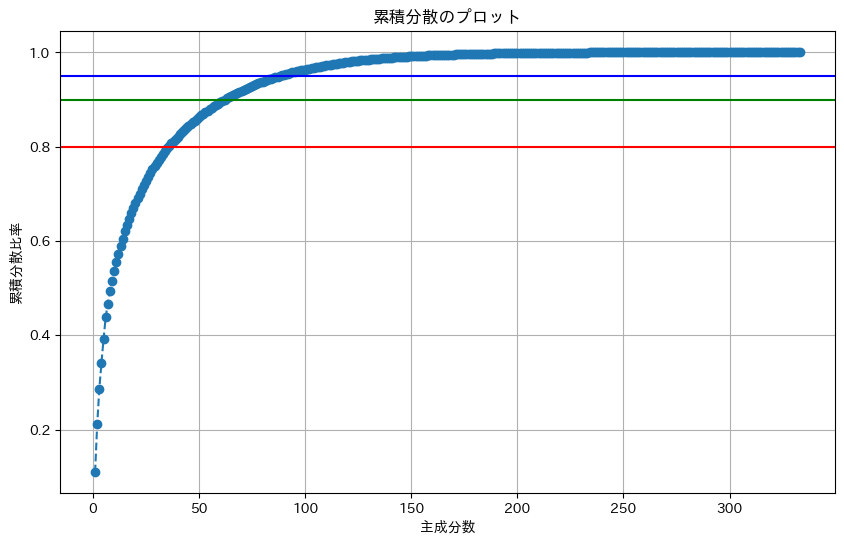

80%の分散を保持する主成分数: 36
90%の分散を保持する主成分数: 63
95%の分散を保持する主成分数: 88


In [65]:
pca = PCA()
df_train_without_target = df_train.drop(['card_id', 'target', 'first_active_month'], axis=1)
pca.fit(df_train_without_target)

# 各主成分の分散比率を取得
explained_variance_ratio = pca.explained_variance_ratio_

# 累積分散を計算
cumulative_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('累積分散のプロット')
plt.xlabel('主成分数')
plt.ylabel('累積分散比率')
plt.grid(True)
plt.axhline(y=0.80, color='r', linestyle='-')
plt.axhline(y=0.90, color='g', linestyle='-')
plt.axhline(y=0.95, color='b', linestyle='-')
plt.show()

num_components_80 = np.where(cumulative_variance >= 0.80)[0][0] + 1
num_components_90 = np.where(cumulative_variance >= 0.90)[0][0] + 1
num_components_95 = np.where(cumulative_variance >= 0.95)[0][0] + 1

print(f'80%の分散を保持する主成分数: {num_components_80}')
print(f'90%の分散を保持する主成分数: {num_components_90}')
print(f'95%の分散を保持する主成分数: {num_components_95}')

In [66]:
#PCA分析
df_test = df_test.drop(['card_id', 'first_active_month'], axis=1)

pca = PCA(n_components=200)
principal_components_train = pca.fit_transform(df_train_without_target)
principal_components_test = pca.fit_transform(df_test)
# 主成分をデータフレームに変換
df_train_without_target = pd.DataFrame(data=principal_components_train)
df_test = pd.DataFrame(data=principal_components_test)

In [67]:
# PCA用
df_train = pd.concat([df_train_without_target, df_train[['target']]], axis=1)

In [46]:
# PCA用
# 再度標準化
# scaler = StandardScaler()
# numeric_cols_train_PCA = df_train.select_dtypes(include=['float64', 'int64']).columns
# numeric_cols_train_PCA = numeric_cols_train_PCA.drop('target')

# numeric_cols_test_PCA = df_test.select_dtypes(include=['float64', 'int64']).columns
# df_train[numeric_cols_train_PCA] = pd.DataFrame(scaler.fit_transform(df_train[numeric_cols_train_PCA]))
# df_test[numeric_cols_test_PCA] = pd.DataFrame(scaler.fit_transform(df_test[numeric_cols_test_PCA]))

In [72]:
# PCA用 # card_idもfirst_active_monthもない
df_train.to_csv('../Kaggle-data/processed/train_processed_clv&churn&ltv_scaled_PCA_200.csv', index=False)
df_test.to_csv('../Kaggle-data/processed/test_processed_clv&churn&ltv_scaled_PCA_200.csv', index=False)

In [73]:
df_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,target
0,-1.027619,11.652585,5.362080,0.027393,1.933503,-1.953584,1.810893,0.397534,1.390822,-4.985131,0.391637,1.763109,-2.204327,-0.069610,0.137710,0.910067,0.934291,1.002518,0.203715,-0.612687,1.991509,0.875809,0.054961,-1.654099,0.085564,0.360003,-0.137774,0.318079,2.760830,1.807328,-0.255651,0.547254,-1.481796,0.238148,0.588808,-0.499697,0.649077,0.026590,1.047173,0.897870,-1.686263,-0.345884,0.091707,-0.803145,-1.151211,-2.080448,-1.426622,0.221914,-0.772017,-0.518790,1.394771,0.258378,-0.150378,-0.451291,1.045838,0.778225,0.054008,-0.754043,-0.203925,-0.803959,0.223204,0.742340,-0.215838,0.632467,0.023661,0.181564,0.190804,-0.336986,0.034334,-0.224179,0.187994,-0.457410,0.473980,-1.598947,-0.075162,-0.638048,1.132664,0.025843,-0.555901,-0.047724,0.175528,0.460662,0.354515,0.789949,0.072621,0.260933,1.081214,-0.252085,-0.095215,-0.433965,0.253080,-0.681442,0.799877,-0.037575,0.299619,-0.467088,0.625520,-0.407014,-0.542308,0.123563,0.541443,-0.127419,-0.315791,-0.059011,-0.115546,0.004991,0.078677,0.297460,-0.213017,-0.039016,0.767778,0.327317,-0.171969,-0.088290,-0.227308,-0.592972,-0.034107,0.022941,-0.276924,0.014422,-0.234313,0.022012,-0.459202,0.358842,0.231884,0.523330,0.223774,-0.583382,-0.370241,0.336796,-0.283788,-0.212123,0.145290,0.323373,0.186611,0.019859,0.328958,0.188489,0.000401,-0.459961,0.089324,0.153924,-0.401924,-0.051578,0.474896,-0.519262,0.600042,0.229046,0.175758,-0.075491,-0.245155,0.157226,0.176059,0.070124,0.016980,0.164095,-0.004053,0.008319,0.542452,0.068517,0.380752,0.081554,-0.180340,-0.408729,-0.087836,0.308833,-0.152632,-0.053590,0.022732,0.191206,0.225256,0.089658,-0.008760,-0.164550,0.075444,-0.030315,0.007305,0.026566,-0.203696,-0.023871,0.194068,-0.136514,0.282268,0.041698,0.039301,0.086167,0.032118,-0.090758,0.103195,-0.061477,-0.039348,0.024805,0.079076,-0.063624,0.009000,0.155065,-0.056189,0.122546,0.069522,-0.134497,-0.820283
1,4.806488,10.655456,-4.272476,-0.107256,-5.005516,4.569037,0.187456,4.024402,2.537707,0.901021,1.039802,2.567823,-0.662398,-0.181689,1.485402,1.021591,-2.696143,1.338587,-0.420187,-0.157470,-0.460876,0.926622,-0.222190,-0.309878,2.078367,0.181212,1.262270,-1.041868,-1.791654,0.894475,-2.390230,1.312280,-0.727727,2.014132,0.327287,-0.480382,-0.881078,-1.617707,-0.331583,1.784876,0.084311,-0.276220,-2.729080,2.900418,0.647435,1.001373,0.686600,0.545704,0.102048,-1.907199,0.418332,-1.388563,1.482054,-1.595798,-0.639026,-0.451511,-0.213626,1.295470,1.270874,0.058005,-0.038699,-1.669356,0.464502,-1.789587,-0.566187,-1.756575,1.183074,-0.680285,-1.048891,-0.735492,0.107190,0.985672,-0.955671,-0.927366,-1.512333,0.048841,-1.113967,-0.799100,-0.575887,-0.163805,0.508429,-0.356462,0.750244,-0.829984,-0.996677,0.259643,-0.617689,-0.203741,-0.482810,-0.427982,0.011279,-0.541254,-0.423596,-0.032389,1.015017,-1.120314,0.350906,0.339145,-0.119351,0.057198,-0.124539,0.028574,0.302718,-0.148469,-0.140595,0.320295,0.158091,0.210451,-0.001784,-0.182370,0.680722,0.431389,0.222955,0.414295,-0.217523,0.401122,0.089130,-0.086876,0.180008,-0.068515,0.257286,0.226589,-0.742628,0.874954,-0.599080,0.791831,0.660759,-0.496474,0.191520,-0.037831,-0.693039,-0.034664,-0.631101,0.060317,0.113030,0.359907,-0.238733,0.268796,0.728361,-0.110002,-0.021812,0.097729,-0.201596,0.140552,0.011093,0.005096,0.268439,0.22763

In [48]:
df_train.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,target
count,2.019170e+05,2.019170e+05,2.019170e+05,2.019170e+05,2.019170e+05,2.019170e+05,2.019170e+05,2.019170e+05,2.019170e+05,2.019170e+05,2.019170e+05,2.019170e+05,2.019170e+05,2.019170e+05,2.019170e+05,2.019170e+05,2.019170e+05,2.019170e+05,2.019170e+05,2.019170e+05,2.019170e+05,2.019170e+05,2.019170e+05,2.019170e+05,2.019170e+05,2.019170e+05,2.019170e+05,2.019170e+05,2.019170e+05,2.019170e+05,2.019170e+05,2.019170e+05,2.019170e+05,2.019170e+05,2.019170e+05,2.019170e+05,2.019170e+05,2.019170e+05,2.019170e+05,2.019170e+05,2.019170e+05,2.019170e+05,2.019170e+05,2.019170e+05,2.019170e+05,2.019170e+05,2.019170e+05,2.019170e+05,2.019170e+05,2.019170e+05,2.019170e+05,2.019170e+05,2.019170e+05,2.019170e+05,2.019170e+05,2.019170e+05,2.019170e+05,2.019170e+05,2.019170e+05,2.019170e+05,2.019170e+05,2.019170e+05,2.019170e+05,2.019170e+05,201917.000000
mean,1.689112e-17,1.097923e-17,2.871491e-17,6.510121e-19,7.741765e-18,-1.302024e-17,-5.876704e-18,-2.055087e-17,2.674428e-18,1.562429e-17,5.859109e-18,-9.782776e-18,-2.004062e-17,-1.319619e-18,2.303175e-17,-7.442652e-18,-6.844424e-18,-8.832650e-18,1.731340e-17,-1.001151e-17,2.410504e-17,1.208771e-17,-9.571637e-18,6.686070e-18,1.224607e-17,-7.741765e-18,2.280302e-17,1.829872e-18,-1.492049e-17,1.506125e-17,-1.231644e-18,-1.576505e-17,1.485011e-17,-5.735944e-18,4.926578e-18,-1.858024e-17,-2.948909e-17,2.127226e-17,-3.040402e-17,5.630375e-19,1.407594e-17,3.518984e-20,-1.791163e-17,7.741765e-18,-1.931922e-17,2.280302e-17,-1.933682e-17,9.008600e-18,2.709618e-18,1.048657e-17,9.290118e-18,-8.586321e-18,-1.393518e-17,2.139542e-17,8.304803e-18,-1.727821e-17,-1.425189e-18,-9.993915e-18,-1.738378e-17,1.622252e-17,1.710226e-17,2.716656e-17,3.128377e-17,-1.770049e-17,-0.393636
std,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,3.850500
min,-2.021993e+00,-1.261941e+01,-2.627793e+01,-8.071302e-01,-2.359931e+01,-2.974048e+01,-2.019106e+01,-5.017318e+01,-6.872373e+00,-1.570406e+01,-3.967213e+01,-1.310522e+02,-3.477997e+01,-2.268329e+01,-5.357006e+01,-2.760373e+01,-7.098295e+01,-8.535059e+00,-1.372280e+01,-2.673996e+01,-5.145643e+01,-8.273970e+00,-9.420137e+00,-7.476709e+01,-2.284528e+01,-1.442739e+01,-5.187095e+01,-1.207673e+01,-5.198814e+01,-5.001425e+01,-1.434428e+01,-2.462968e+01,-5.846166e+01,-2.660878e+01,-1.640258e+01,-5.308246e+01,-5.488635e+01,-4.438365e+01,-3.133026e+01,-5.950338e+01,-2.887922e+01,-8.777426e+01,-2.678021e+01,-7.467470e+01,-3.165556e+01,-2.790768e+01,-6.161503e+01,-1.068407e+01,-2.710497e+01,-5.499242e+01,-4.294385e+01,-1.667595e+02,-1.806828e+02,-2.057381e+01,-3.211936e+01,-3.681898e+01,-5.480432e+00,-1.228181e+01,-1.491751e+01,-2.159481e+01,-4.392275e+01,-2.671056e+01,-2.934504e+01,-4.113752e+01,-33.219281
25%,-8.087489e-01,-6.934703e-01,-7.387817e-01,-3.619770e-02,-6.303399e-01,-6.095422e-01,-3.832877e-01,-6.206498e-01,-7.343414e-01,-6.580379e-01,-3.391238e-01,-5.136648e-01,-6.640592e-01,-3.873895e-02,-5.354395e-01,-6.136416e-01,-5.129538e-01,-5.822800e-01,-6.719491e-01,-5.971025e-01,-5.960715e-01,-4.164066e-01,-5.464904e-01,

In [9]:
# # 特徴量とターゲットの分割
# X = df_train.drop(['card_id', 'target', 'first_active_month'], axis=1)
# y = df_train['target']

# PCA用
X = df_train.drop(['target'], axis=1)
y = df_train['target']


# # オートエンコーダーの構築
input_dim = X.shape[1]
# encoding_dim = 128

# input_layer = Input(shape=(input_dim,))
# encoded = Dense(encoding_dim, activation='relu')(input_layer)
# decoded = Dense(input_dim, activation='sigmoid')(encoded)

# autoencoder = Model(input_layer, decoded)
# autoencoder.compile(optimizer=Adam, loss='mse')
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# # オートエンコーダーの訓練
# autoencoder.fit(X, X, epochs=150, batch_size=256, shuffle=True)

# # 特徴量の抽出
# encoder = Model(input_layer, encoded)
# X_encoded = encoder.predict(X)

# KFoldによる交差検証
kf = KFold(n_splits=3, shuffle=True, random_state=42)
rmse_scores = []
mae_scores = []

for train_index, valid_index in kf.split(X):
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index] # auto-encodeを使うならX→X_encodedにする
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    model = Sequential([
        Dense(256, activation='relu', input_shape=(input_dim,)), # auto-encodeを使うならinput_dim→encoding_dimにする
        # LeakyReLU(alpha=0.01),
        Dropout(0.2),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(128, activation='relu'),
        Dropout(0.1),
        Dense(64, activation='relu'),
        Dropout(0.05),
        # Dense(32, activation='relu'),
        # Dropout(0),
        # Dense(16, activation='relu'),
        # Dropout(0),
        Dense(1)
    ])

    model.compile(optimizer=Adam(learning_rate=0.00005), loss='mean_squared_error', metrics=['mae'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min')

    history = model.fit(X_train, y_train, epochs=150, batch_size=256, validation_data=(X_valid, y_valid), callbacks=[early_stopping], verbose=1)

    y_pred = model.predict(X_valid)
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    mae = mean_absolute_error(y_valid, y_pred)
    
    rmse_scores.append(rmse)
    mae_scores.append(mae)

C:\Users\toshiki.kawai.sx\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/150
526/526 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 15.3655 - mae: 1.6138 - val_loss: 14.6795 - val_mae: 1.5951
Epoch 2/150
526/526 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 14.3851 - mae: 1.5812 - val_loss: 14.3986 - val_mae: 1.5943
Epoch 3/150
526/526 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 14.1173 - mae: 1.5829 - val_loss: 14.2131 - val_mae: 1.5865
Epoch 4/150
526/526 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 13.7464 - mae: 1.5775 - val_loss: 14.0779 - val_mae: 1.5971
Epoch 5/150
526/526 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 14.0130 - mae: 1.5991 - val_loss: 14.0089 - val_mae: 1.5803
Epoch 6/150
526/526 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 13.8062 - mae: 1.5903 - val_loss: 13.9234 - val_mae: 1.5828
Epoch 7/150
526/526 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 13.5819 - mae: 1.5810 - val_loss: 13.8806 - val_mae: 1.5842
Epoch 8/150
526/526 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 13.6390 - mae: 1.5857 - val_loss: 13.8232 - val_mae: 1.5842
Epoch 9/150
526/526 ━━━━━━━━━━━━

C:\Users\toshiki.kawai.sx\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


526/526 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 15.0733 - mae: 1.5931 - val_loss: 14.8023 - val_mae: 1.5492
Epoch 2/150
526/526 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 14.2871 - mae: 1.5795 - val_loss: 14.6011 - val_mae: 1.5606
Epoch 3/150
526/526 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 14.6072 - mae: 1.6061 - val_loss: 14.4331 - val_mae: 1.5842
Epoch 4/150
526/526 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 14.0781 - mae: 1.5979 - val_loss: 14.3273 - val_mae: 1.5668
Epoch 5/150
526/526 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 14.0470 - mae: 1.5930 - val_loss: 14.2189 - val_mae: 1.5837
Epoch 6/150
526/526 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 13.7555 - mae: 1.5930 - val_loss: 14.1503 - val_mae: 1.5798
Epoch 7/150
526/526 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 12.9837 - mae: 1.5713 - val_loss: 14.0862 - val_mae: 1.5999
Epoch 8/150
526/526 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 13.8399 - mae: 1.6039 - val_loss: 14.0468 - val_mae: 1.5829
Epoch 9/150
526/526 ━━━━━━━━━━━━━━━━━━━━ 2s 

C:\Users\toshiki.kawai.sx\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


526/526 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 15.3736 - mae: 1.6054 - val_loss: 13.8103 - val_mae: 1.5378
Epoch 2/150
526/526 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 15.0565 - mae: 1.6060 - val_loss: 13.5913 - val_mae: 1.5513
Epoch 3/150
526/526 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 14.5413 - mae: 1.6070 - val_loss: 13.4446 - val_mae: 1.5504
Epoch 4/150
526/526 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 14.1002 - mae: 1.5985 - val_loss: 13.3414 - val_mae: 1.5601
Epoch 5/150
526/526 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 14.0033 - mae: 1.6027 - val_loss: 13.2644 - val_mae: 1.5491
Epoch 6/150
526/526 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 14.1913 - mae: 1.6103 - val_loss: 13.2025 - val_mae: 1.5596
Epoch 7/150
526/526 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 14.0797 - mae: 1.6100 - val_loss: 13.1808 - val_mae: 1.5371
Epoch 8/150
526/526 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 14.3562 - mae: 1.6127 - val_loss: 13.1391 - val_mae: 1.5697
Epoch 9/150
526/526 ━━━━━━━━━━━━━━━━━━━━ 2s 

In [10]:
print(f'Cross-Validated RMSE: {np.mean(rmse_scores)} ± {np.std(rmse_scores)}')
print(f'Cross-Validated MAE: {np.mean(mae_scores)} ± {np.std(mae_scores)}')

Cross-Validated RMSE: 3.6781780796063557 ± 0.04926129814792229
Cross-Validated MAE: 1.5524570049553519 ± 0.008880271519574007


In [11]:
model.save('NN_model.keras')
print('モデルが保存されました')

モデルが保存されました


In [ ]:
# 特徴量とターゲットの分割
# X = df_train.drop(['card_id', 'target', 'first_active_month'], axis=1)
# y = df_train['target']

# # オートエンコーダーの構築
# input_dim = X.shape[1]
# encoding_dim = 128

# input_layer = Input(shape=(input_dim,))
# encoded = Dense(encoding_dim, activation='relu')(input_layer)
# decoded = Dense(input_dim, activation='sigmoid')(encoded)

# autoencoder = Model(input_layer, decoded)
# autoencoder.compile(optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, decay=0.0, amsgrad=False), loss='mean_squared_error')
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# # オートエンコーダーの訓練
# autoencoder.fit(X, X, epochs=50, batch_size=256, shuffle=True)

# # 特徴量の抽出
# encoder = Model(input_layer, encoded)
# X_encoded = encoder.predict(X)

# # KFoldによる交差検証
# kf = KFold(n_splits=3, shuffle=True, random_state=42)
# rmse_scores = []
# mae_scores = []

# for train_index, valid_index in kf.split(X_encoded):
#     X_train, X_valid = X_encoded[train_index], X_encoded[valid_index]
#     y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
#     model = Sequential([
#         Dense(256, activation='relu', input_shape=(encoding_dim,)), # auto-encodeを使うならinput_dim→encoding_dimにする
#         # LeakyReLU(alpha=0.01),
#         Dropout(0.2),
#         Dense(128, activation='relu'),
#         Dropout(0.2),
#         Dense(128, activation='relu'),
#         Dropout(0.1),
#         Dense(64, activation='relu'),
#         Dropout(0),
#         Dense(1)
#     ])

#     model.compile(optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, decay=0.0, amsgrad=False), loss='mean_squared_error', metrics=['mae'])

#     early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, mode='min')

#     history = model.fit(X_train, y_train, epochs=150, batch_size=256, validation_data=(X_valid, y_valid), callbacks=[early_stopping], verbose=1)

#     y_pred = model.predict(X_valid)
#     rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
#     mae = mean_absolute_error(y_valid, y_pred)
    
#     rmse_scores.append(rmse)
    # mae_scores.append(mae)

In [ ]:
# print(f'Cross-Validated RMSE: {np.mean(rmse_scores)} ± {np.std(rmse_scores)}')
# print(f'Cross-Validated MAE: {np.mean(mae_scores)} ± {np.std(mae_scores)}')

In [ ]:
# model.save('NN_ac_model.keras')
# print('モデルが保存されました')

In [ ]:
# dropput_rate = 0.2
# learning_rate = 0.00001

# model = Sequential([
#     Dense(256, input_shape=(X_train.shape[1],)),
#     LeakyReLU(alpha=0.01),
#     Dropout(dropout_rate),
#     # Dense(512),
#     # LeakyReLU(alpha=0.01),
#     # Dense(256),
#     # LeakyReLU(alpha=0.01),
#     Dense(128, activation='relu'),
#     Dropout(dropout_rate),
#     Dense(64, activation='relu'),
#     Dropout(dropout_rate),
#     # Dense(32),
#     # LeakyReLU(alpha=0.01),
#     # Dense(16),
#     # LeakyReLU(alpha=0.01),
#     # Dense(16, activation='relu'),  # コメントアウトされたReLUの代替案
#     Dense(1)  # 出力層: ニューロン1つ（回帰の場合は活性化関数を指定しない）
# ])

# # モデルのコンパイル
# model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error', metrics=['mae'])

In [ ]:
# history = model.fit(X_train, y_train, epochs=150, batch_size=256, validation_split=0.3
#                     , callbacks=[early_stopping]
#                     )
# winsound.Beep(frequency, duration)

In [ ]:
# loss, mae = model.evaluate(X_valid, y_valid)
# print(f'Val Root Mean Squared Error: {np.sqrt(loss)}')
# print(f'Val Mean Absolute Error: {mae}')

In [ ]:
# model.save('NN_model.keras')
# print('モデルが保存されました')

In [ ]:
# 予測値と訓練データの残差をプロット
plt.scatter(y_pred,             # グラフのx値(予測値)を定義
            y_pred - y_train,   # グラフのy値(予測値と訓練データの差)を定義
            c='red',                 # プロットの色を指定
            marker='o',               # マーカーの種類
            s=20,                     # マーカーのサイズ
            alpha=0.3,                # グラフの透過度
            label='train_data')         # ラベル名


# 予測値とテストデータの残差をプロット
plt.scatter(y_pred,
            y_pred - y_valid,
            c='green',
            marker='o',
            s=20,
            alpha=0.3,
            label='validation_data')

# グラフの詳細設定を行う
plt.xlabel('predict')
plt.ylabel('Residual error')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-20, xmax=20, lw=2, color='black')
plt.xlim([-25, 25])
plt.ylim([-50, 50])
plt.tight_layout()
plt.grid(True)
plt.show()

In [ ]:
# pd.set_option('display.max_rows', None)
df_train.columns